In [ ]:
# Gaia observables in galaxia mock

In [166]:
# Python imports
from importlib import reload
import os
import numpy as np
import astropy.io.fits as fits
import astropy.coordinates as c
from astropy.table import Table
import astropy.units as u
import mpl_toolkits.basemap
import matplotlib.pyplot as pl
import astropy.table as table
import scipy.optimize as spo

In [5]:
# Desi-specific imports
import desitarget.io
import desitarget.mock.io as mock_io
from desitarget import mws_mask
import desiutil.plots as desiplots
import bright_analysis.sweeps.io as sweeps
reload(sweeps);

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data setup

In [9]:
!ls /gpfs/data/DESI/mocks/mws/galaxia/alpha/0.0.4/gaia/005/0050m100/allsky_galaxia_desi_0050m100.gaia.fits

/gpfs/data/DESI/mocks/mws/galaxia/alpha/0.0.4/gaia/005/0050m100/allsky_galaxia_desi_0050m100.gaia.fits


In [55]:
MOCK_ROOT    = '/gpfs/data/DESI/mocks/mws/galaxia/alpha/0.0.4/'

In [56]:
gaia_iter = desitarget.io.iter_files(os.path.join(MOCK_ROOT,'gaia'),'allsky_galaxia_desi')

In [57]:
gaia = list()
for gaia_file in gaia_iter:
    gaia.append(fits.getdata(gaia_file))
gaia = np.concatenate(gaia)

In [58]:
mock_iter = desitarget.io.iter_files(os.path.join(MOCK_ROOT,'bricks'),'allsky_galaxia_desi')

In [59]:
mock = list()
for mock_file in list(mock_iter):
    mock.append(fits.getdata(mock_file))
mock = np.concatenate(mock)

In [60]:
nstar = len(mock)
print(nstar)

41677420


In [61]:
print(mock.dtype.names)

('X', 'Y', 'Z', 'l', 'b', 'RA', 'DEC', 'pm_l', 'pm_b', 'pm_RA', 'pm_DEC', 'pm_l_kms', 'pm_b_kms', 'pm_RA_kms', 'pm_DEC_kms', 'v_helio', 'd_helio', 'DM', 'ABV', 'SDSSu_true_nodust', 'SDSSu_true', 'SDSSu_obs', 'SDSSg_true_nodust', 'SDSSg_true', 'SDSSg_obs', 'SDSSr_true_nodust', 'SDSSr_true', 'SDSSr_obs', 'SDSSi_true_nodust', 'SDSSi_true', 'SDSSi_obs', 'SDSSz_true_nodust', 'SDSSz_true', 'SDSSz_obs', 'FeH', 'age', 'teff', 'logg', 'mtip', 'mact', 'smass', 'popid', 'brickname', 'brickid', 'vRcyl', 'vPHIcyl', 'vZcyl', 'vX', 'vY', 'vZ', 'vU', 'vV', 'vW', 'objid')


In [62]:
print(gaia.dtype.names)

('V_Lupton_nodust', 'I_Lupton_nodust', 'V_Lupton', 'I_Lupton', 'G_gaia', 'G_gaia_rvs', 'pm_RA_gaia_error', 'pm_DEC_gaia_error', 'pm_RA_star_gaia', 'pm_DEC_gaia', 'parallax_gaia_error', 'parallax_gaia', 'v_helio_gaia_error_G0V', 'v_helio_gaia_G0V', 'v_helio_gaia_error_F0V', 'v_helio_gaia_F0V', 'v_helio_gaia_error_K1III', 'v_helio_gaia_K1III', 'v_helio_gaia_error_K1IIIMP', 'v_helio_gaia_K1IIIMP')


# Parallax 

In [216]:
np.random.seed(2020)
ridx_nstar = np.unique(np.random.choice(np.arange(0,nstar),size=100000))
nsample = len(ridx)
print('Randomly sampling {}/{}'.format(nsample,nstar))

Randomly sampling 99862/41677420


In [65]:
distance = mock['d_helio'] # kpc

In [215]:
plx_gaia = gaia['parallax_gaia']

In [222]:
# Inflate the errors
plx_gaia_dr2 = np.random.normal(1.0/distance,6.0*gaia['parallax_gaia_error']) # mas

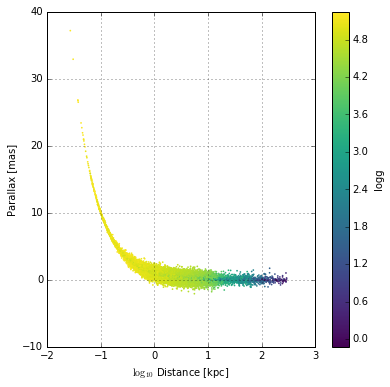

In [237]:
f = pl.figure(figsize=(6,6))
scatter(np.log10(distance[ridx_nstar]),plx_gaia[ridx_nstar],s=3,edgecolor='None',c=mock['logg'][ridx_nstar],cmap='viridis')
pl.colorbar(label='logg')
pl.xlim(-2,3)
pl.ylim(-10,40)
pl.xlabel('$\log_{10}$ Distance [kpc]')
pl.ylabel('Parallax [mas]')
pl.grid()

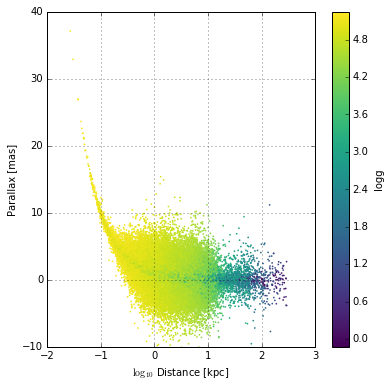

In [238]:
f = pl.figure(figsize=(6,6))
scatter(np.log10(distance[ridx_nstar]),plx_gaia_dr2[ridx_nstar],s=3,edgecolor='None',c=mock['logg'][ridx_nstar],cmap='viridis')
pl.colorbar(label='logg')
pl.xlim(-2,3)
pl.ylim(-10,40)
pl.xlabel('$\log_{10}$ Distance [kpc]')
pl.ylabel('Parallax [mas]')
pl.grid()

In [239]:
np.sum(plx_gaia > 4.0)

860164

# Proper motion vs. distance

In [64]:
pm_gaia = np.sqrt(gaia['pm_DEC_gaia']**2 + gaia['pm_RA_star_gaia']**2) # mas/yr

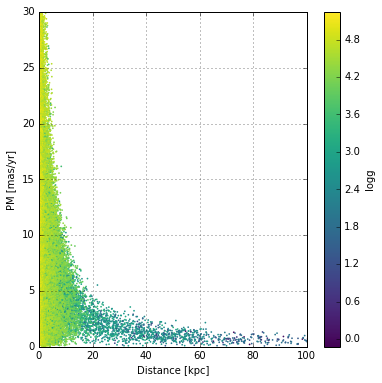

In [240]:
f = pl.figure(figsize=(6,6))
scatter(distance[ridx],pm_gaia[ridx],s=3,edgecolor='None',c=mock['logg'][ridx],cmap='viridis')
pl.colorbar(label='logg')
pl.xlim(0,100)
pl.ylim(0,30)
pl.xlabel('Distance [kpc]')
pl.ylabel('PM [mas/yr]')
pl.grid()

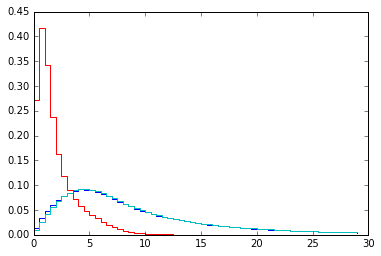

In [174]:
h,b = np.histogram(pm_gaia,bins=np.arange(0,30,0.5),normed=True)
pl.plot(b[:-1],h,drawstyle='steps-post')
h,b = np.histogram(pm_gaia[mock['logg']>3.0],bins=np.arange(0,30,0.5),normed=True)
pl.plot(b[:-1],h,drawstyle='steps-post',c='c')
h,b = np.histogram(pm_gaia[mock['logg']<3.0],bins=np.arange(0,30,0.5),normed=True)
pl.plot(b[:-1],h,drawstyle='steps-post',c='r')

In [191]:
pm_ra_gaia_error  = gaia['pm_RA_gaia_error']*6.0
pm_DEC_gaia_error = gaia['pm_DEC_gaia_error']*6.0

mu_ra_star_with_error = np.random.normal(mock['pm_RA'],pm_ra_gaia_error)
mu_dec_with_error     = np.random.normal(mock['pm_DEC'],pm_ra_gaia_error)

In [195]:
pm_gaia_dr2 = np.sqrt(mu_dec_with_error**2 + mu_ra_star_with_error**2) # mas/yr

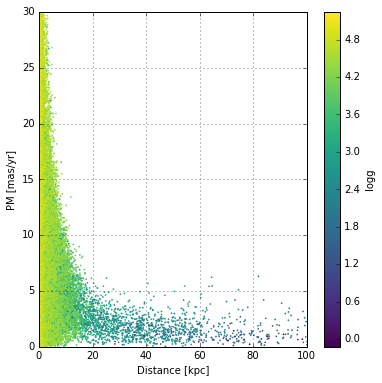

In [241]:
f = pl.figure(figsize=(6,6))
scatter(distance[ridx],pm_gaia_dr2[ridx],s=3,edgecolor='None',c=mock['logg'][ridx],cmap='viridis')
pl.colorbar(label='logg')
pl.xlim(0,100)
pl.ylim(0,30)
pl.xlabel('Distance [kpc]')
pl.ylabel('PM [mas/yr]')
pl.grid()

In [206]:
# What fraction of stars do we eliminate with pm > 10?
pm_high  = pm_gaia > 10
mws_main = mock['SDSSr_obs'] > 19.0
print(mws_main.sum())
print(pm_high.sum())
print((pm_high & mws_main).sum())
print((pm_high & mws_main).sum()/mws_main.sum())

12877057
14960892
4102255
0.318570850467


In [214]:
# What fraction of stars do we eliminate with pm > 5?
pm_gt5  = pm_gaia > 5
print(pm_gt5.sum())
print((pm_gt5 & mws_main).sum())
print((pm_gt5 & mws_main).sum()/mws_main.sum())

28674931
8472978
0.657990253518


In [248]:
highlat  = np.abs(mock['b']) > 50
print((pm_high & mws_main & highlat).sum())
print((pm_high & mws_main & highlat).sum()/(mws_main & highlat).sum())

1071941
0.429945507825


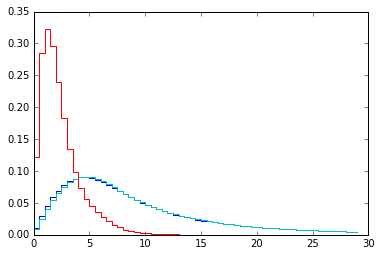

In [199]:
h,b = np.histogram(pm_gaia_dr2,bins=np.arange(0,30,0.5),normed=True)
pl.plot(b[:-1],h,drawstyle='steps-post')
h,b = np.histogram(pm_gaia_dr2[mock['logg']>3.0],bins=np.arange(0,30,0.5),normed=True)
pl.plot(b[:-1],h,drawstyle='steps-post',c='c')
h,b = np.histogram(pm_gaia_dr2[mock['logg']<3.0],bins=np.arange(0,30,0.5),normed=True)
pl.plot(b[:-1],h,drawstyle='steps-post',c='r')

In [210]:
np.random.seed(2020)
main_ridx = np.unique(np.random.choice(np.arange(0,mws_main.sum()),size=100000))
nsample_main = len(main_ridx)
print('Randomly sampling {}/{}'.format(nsample_main,mws_main.sum()))

Randomly sampling 99627/12877057


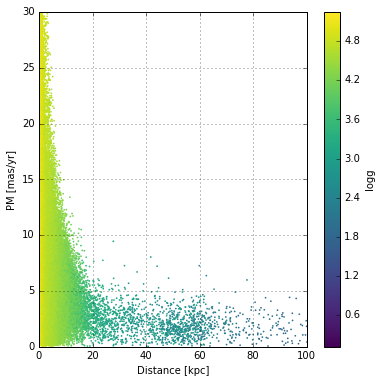

In [213]:
f = pl.figure(figsize=(6,6))
scatter((distance[mws_main])[main_ridx],(pm_gaia_dr2[mws_main])[main_ridx],
        s=3,edgecolor='None',c=(mock['logg'][mws_main])[main_ridx],cmap='viridis')
pl.colorbar(label='logg')
pl.xlim(0,100)
pl.ylim(0,30)
pl.xlabel('Distance [kpc]')
pl.ylabel('PM [mas/yr]')
pl.grid()

/gpfs/data/dph3apc/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


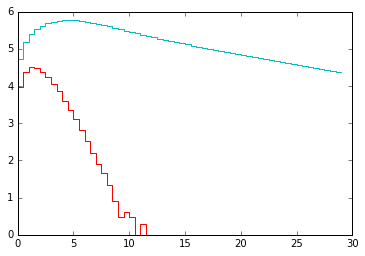

In [209]:
h,b = np.histogram(pm_gaia_dr2[mws_main & (mock['logg']>=3.0)],bins=np.arange(0,30,0.5))
pl.plot(b[:-1],np.log10(h),drawstyle='steps-post',c='c')
h,b = np.histogram(pm_gaia_dr2[mws_main & (mock['logg']<3.0)],bins=np.arange(0,30,0.5))
pl.plot(b[:-1],np.log10(h),drawstyle='steps-post',c='r');

In [ ]:
f = pl.figure(figsize=(6,6))
scatter((distance[mws_main])[main_ridx],(pm_gaia_dr2[mws_main])[main_ridx],
        s=3,edgecolor='None',c=(mock['logg'][mws_main])[main_ridx],cmap='viridis')
pl.colorbar(label='logg')
pl.xlim(0,100)
pl.ylim(0,30)
pl.xlabel('Distance [kpc]')
pl.ylabel('PM [mas/yr]')
pl.grid()